<a href="https://colab.research.google.com/github/oliveirasWell/adult-dataset-mlp-rbf/blob/master/MLP_Adult_income_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Inicialmente iremos instalar algumas bibliotecas auxiliares

install.packages("reshape2")
install.packages("Hmisc")
library(reshape2)
library(Hmisc)

# Lib para plotar dados
install.packages("yardstick")
library(yardstick)
library(ggplot2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Implementar algumas funções auxiliares
quantidade.colunas <- function(matriz){
  return(ncol(t(t(matriz))))
}

In [ ]:
# Primeiro vamos implementar uma função de ativação
funcao.ativacao <- function(v){

  # Função logística
  y <- 1 / (1 + exp(-v))

  return(y)
}

In [ ]:
# Vamos também precisar da derivada da função de ativação
der.funcao.ativacao <- function(y){

  # Derivada da logística
  derivada <- y * (1 - y)

  return(derivada)
}

In [ ]:
# Vamos criar uma arquitetura para nossa MLP
arquitetura <- function(num.entrada, num.escondida, num.saida,
                        funcao.ativacao, der.funcao.ativacao){

  arq <- list()

  # Parametros da rede    
  arq$num.entrada <- num.entrada
  arq$num.escondida <- num.escondida
  arq$num.saida <- num.saida
  arq$funcao.ativacao <- funcao.ativacao
  arq$der.funcao.ativacao <- der.funcao.ativacao

  # Pesos conectando entrada e escondida
  num.pesos.entrada.escondida <- (num.entrada+1)*num.escondida
  arq$escondida <- matrix(runif(min=-0.5,max=0.5, num.pesos.entrada.escondida),
                                nrow=num.escondida, ncol=num.entrada+1)

  # Pesos conectando escondida e saida
  num.pesos.escondida.saida <- (num.escondida+1)*num.saida
  arq$saida <- matrix(runif(min=-0.5,max=0.5,  num.pesos.escondida.saida),
                            nrow=num.saida, ncol=num.escondida+1)


  return(arq)
}

In [ ]:
mlp.propagacao <- function(arq, exemplo){

  # Entrada -> Cama Escondida
  v.entrada.escondida <- arq$escondida %*% as.numeric(c(exemplo,1))
  y.entrada.escondida <- arq$funcao.ativacao(v.entrada.escondida)

  # Camada Escondida -> Camada de Saida
  v.escondida.saida <- arq$saida %*% c(y.entrada.escondida,1)
  y.escondida.saida <- arq$funcao.ativacao(v.escondida.saida)

  # Resultados
  resultado <- list()
  resultado$v.entrada.escondida <- v.entrada.escondida
  resultado$y.entrada.escondida <- y.entrada.escondida
  resultado$v.escondida.saida <- v.escondida.saida
  resultado$y.escondida.saida <- y.escondida.saida

  return(resultado)
}


In [ ]:
mlp.retropropagacao <- function(arq, dados, n, limiar){

  erroQuadratico <- 2 * limiar
  epocas <- 0

  # Treina eqto o erro quadratico for maior que um limiar
  while(erroQuadratico > limiar){
    erroQuadratico <- 0

    # Treino para todos os exemplos (epoca)
    for(i in 1:nrow(dados)){

      # Pego um exemplo de entrada
      x.entrada <- dados[i,1:arq$num.entrada]
      x.saida <- dados[i,ncol(dados)]

      # Pego a saida da rede para o exemplo
      resultado <- mlp.propagacao(arq,x.entrada)
      y <- resultado$y.escondida.saida

      # Calculo do erro para o exemplo

      erro <- x.saida - y

      # Soma erro quadratico
      erroQuadratico <- erroQuadratico + erro*erro

      # Gradiente local no neuronio de saida
      # erro * derivada da funcao de ativacao
      grad.local.saida <- erro * arq$der.funcao.ativacao(y)

      # Gradiente local no neuronio escondido
      # derivada da funcao de ativacao no neuronio escondido * soma dos gradientes
      # locais dos neuronios conectados na proxima camada * pesos conectando a camada
      # escondida com a saida
      pesos.saida <- arq$saida[,1:arq$num.escondida]
      grad.local.escondida <-
        as.numeric(arq$der.funcao.ativacao(resultado$y.entrada.escondida)) *
        (grad.local.saida %*% pesos.saida)

      # Ajuste dos pesos
      # Saida
      arq$saida <- arq$saida + n * (grad.local.saida %*%
                                     c(resultado$y.entrada.escondida,1))
      # Escondida
      arq$escondida <- arq$escondida + n * (t(grad.local.escondida) %*%
                                             as.numeric(c(x.entrada,1)))
    } # Fim for(i in 1:nrow(dados))

    print(nrow(dados))
    erroQuadratico <- erroQuadratico / nrow(dados)
    cat("Erro Quadratico Medio = ",erroQuadratico, "\n")
    epocas <- epocas+1
    
  } # Fim while(erroQuadratico > limiar)

  retorno <- list()
  retorno$arq <- arq
  retorno$epocas <- epocas

  return(retorno)
}

In [ ]:
# Leitura da tabela representando os dados do censo
dados <- read.csv('sample_data/adult.data', header=FALSE, strip.white=TRUE)
head(dados)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [ ]:
colnames(dados) <- c("age",
                     "workclass", 
                     "fnlwgt",
                     "education",
                     "education-num",
                     "marital",
                      "occupation",
                      "relationship",
                      "race",
                      "sex", 
                      "capital-gain", 
                      "capital-loss",
                      "hours-per-week",
                      "country",
                      "income"
)

dim(dados)
summary(dados)

[1] 32561    15

      age         workclass             fnlwgt         education        
 Min.   :17.00   Length:32561       Min.   :  12285   Length:32561      
 1st Qu.:28.00   Class :character   1st Qu.: 117827   Class :character  
 Median :37.00   Mode  :character   Median : 178356   Mode  :character  
 Mean   :38.58                      Mean   : 189778                     
 3rd Qu.:48.00                      3rd Qu.: 237051                     
 Max.   :90.00                      Max.   :1484705                     
 education-num     marital           occupation        relationship      
 Min.   : 1.00   Length:32561       Length:32561       Length:32561      
 1st Qu.: 9.00   Class :character   Class :character   Class :character  
 Median :10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10.08                                                           
 3rd Qu.:12.00                                                           
 Max.   :16.00                               

In [ ]:
str(dados)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  "State-gov" "Self-emp-not-inc" "Private" "Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  "Bachelors" "Bachelors" "HS-grad" "11th" ...
 $ education-num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital       : chr  "Never-married" "Married-civ-spouse" "Divorced" "Married-civ-spouse" ...
 $ occupation    : chr  "Adm-clerical" "Exec-managerial" "Handlers-cleaners" "Handlers-cleaners" ...
 $ relationship  : chr  "Not-in-family" "Husband" "Not-in-family" "Husband" ...
 $ race          : chr  "White" "White" "White" "Black" ...
 $ sex           : chr  "Male" "Male" "Male" "Male" ...
 $ capital-gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital-loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours-per-week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ country       : chr  "United-States" "Uni

In [ ]:
prop.table(table(dados$income))


    <=50K      >50K 
0.7591904 0.2408096 

In [ ]:
#dados$education <- as.factor(dados$education)
#dados$workclass <- as.factor(dados$workclass)
#dados$occupation <- as.factor(dados$occupation)
#dados$relationship <- as.factor(dados$relationship)
#dados$race <- as.factor(dados$race)
#dados$sex <- as.factor(dados$sex)
#dados$income <- as.factor(dados$income)
#dados$"marital-status" <- as.factor(dados$"marital-status")
#dados$"native-country" <- as.factor(dados$"native-country")

str(dados)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  "State-gov" "Self-emp-not-inc" "Private" "Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  "Bachelors" "Bachelors" "HS-grad" "11th" ...
 $ education-num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital       : chr  "Never-married" "Married-civ-spouse" "Divorced" "Married-civ-spouse" ...
 $ occupation    : chr  "Adm-clerical" "Exec-managerial" "Handlers-cleaners" "Handlers-cleaners" ...
 $ relationship  : chr  "Not-in-family" "Husband" "Not-in-family" "Husband" ...
 $ race          : chr  "White" "White" "White" "Black" ...
 $ sex           : chr  "Male" "Male" "Male" "Male" ...
 $ capital-gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital-loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours-per-week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ country       : chr  "United-States" "Uni

In [ ]:
# Vamos remover elementos nulos 

# a. Número de exemplos
8080
# b. Número de atributos
dim(dados)

[1] 8080

[1] 32561    15

In [ ]:
# c. Número de atributos numéricos
print(6)


[1] 6


In [ ]:

# d. Número de atributos categóricos
print(9)


[1] 9


In [ ]:
# e. Número de atributos com valores ausentes

length(dados[dados == "?"])


[1] 4262

In [ ]:
# Ajusta os dados de saída 
# Não muito balanceado
# "<=50K",">50K"

dados$income[dados$income == "<=50K"] <- 1
dados$income[dados$income == ">50K"] <- 0

dados$income = as.integer(as.character(dados$income))

table(dados$income)


    0     1 
 7841 24720 

In [ ]:
#@title
# Arrumando os dados faltantes 
# Foi utilizada a estratégia de moda para todos os elementos

dados$workclass[dados$workclass == "?"] <- mode(dados$workclass)
table(dados$workclass)


       character      Federal-gov        Local-gov     Never-worked 
            1836              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1298 
     Without-pay 
              14 

In [ ]:
dados$education[dados$education == "?"] <- mode(dados$education)
table(dados$education)


        10th         11th         12th      1st-4th      5th-6th      7th-8th 
         933         1175          433          168          333          646 
         9th   Assoc-acdm    Assoc-voc    Bachelors    Doctorate      HS-grad 
         514         1067         1382         5355          413        10501 
     Masters    Preschool  Prof-school Some-college 
        1723           51          576         7291 

In [ ]:
dados$occupation[dados$occupation == "?"] <- mode(dados$occupation)
table(dados$occupation)


     Adm-clerical      Armed-Forces         character      Craft-repair 
             3770                 9              1843              4099 
  Exec-managerial   Farming-fishing Handlers-cleaners Machine-op-inspct 
             4066               994              1370              2002 
    Other-service   Priv-house-serv    Prof-specialty   Protective-serv 
             3295               149              4140               649 
            Sales      Tech-support  Transport-moving 
             3650               928              1597 

In [ ]:
dados$relationship[dados$relationship == "?"] <- mode(dados$relationship)
table(dados$relationship)


       Husband  Not-in-family Other-relative      Own-child      Unmarried 
         13193           8305            981           5068           3446 
          Wife 
          1568 

In [ ]:
dados$race[dados$race == "?"] <- mode(dados$race)
table(dados$race)


Amer-Indian-Eskimo Asian-Pac-Islander              Black              Other 
               311               1039               3124                271 
             White 
             27816 

In [ ]:
dados$sex[dados$sex == "?"] <- mode(dados$sex)
table(dados$sex)


Female   Male 
 10771  21790 

In [ ]:
dados$"marital"[dados$"marital"  == "?"] <- mode(dados$"marital" )
table(dados$"marital")


             Divorced     Married-AF-spouse    Married-civ-spouse 
                 4443                    23                 14976 
Married-spouse-absent         Never-married             Separated 
                  418                 10683                  1025 
              Widowed 
                  993 

In [ ]:
dados$"country"[dados$"country" == "?"] <- mode(dados$"country")
table(dados$"country")


                  Cambodia                     Canada 
                        19                        121 
                 character                      China 
                       583                         75 
                  Columbia                       Cuba 
                        59                         95 
        Dominican-Republic                    Ecuador 
                        70                         28 
               El-Salvador                    England 
                       106                         90 
                    France                    Germany 
                        29                        137 
                    Greece                  Guatemala 
                        29                         64 
                     Haiti         Holand-Netherlands 
                        44                          1 
                  Honduras                       Hong 
                        13                         20 
         

In [ ]:
# Constatando que eliminamos todos os elementos nulos do conjunto
length(dados[dados == "?"])

[1] 0

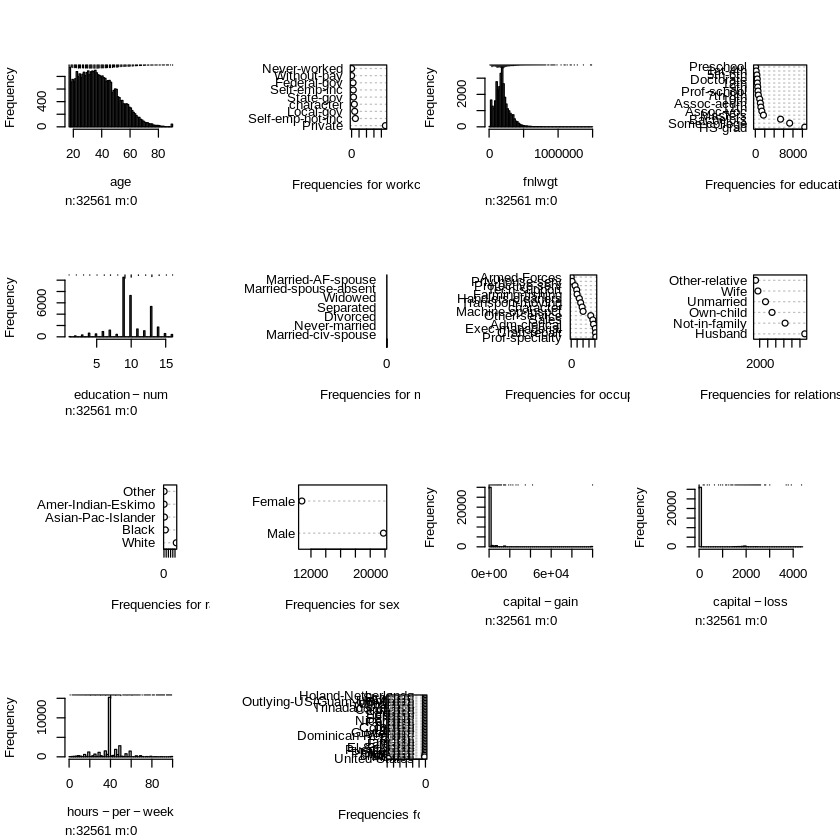

In [ ]:
hist.data.frame(dados, na.big = TRUE, rugs = TRUE)

In [ ]:
# remove columnas que não conseguimos tratar

dados <-  subset( dados, select = -education )
dados <-  subset( dados, select = -occupation )
dados <-  subset( dados, select = -workclass )
dados <-  subset( dados, select = -relationship )
dados <-  subset( dados, select = -race )
dados <-  subset( dados, select = -sex )
dados <-  subset( dados, select = -marital )
dados <-  subset( dados, select = -country )

#dados$workclass <- NA
#dados$occupation <- NA
#dados$relationship <- NA
#dados$race <- NA
#dados$sex <- NA
#dados$"marital-status" <- NA
#dados$"native-country" <- NA


In [ ]:
# Uma das práticas da estatística é a normalização dos dados com: centralização da média em zero e escala em desvio padrão
dados[c(1,2,3,4,5,6)] <- scale(dados[c(1,2,3,4,5,6)])


In [ ]:
# Vamos escolher aleatoriamente dados para treino e teste.
# O conjunto de dados já está randomizado. 
# Assim, Vamos pegar os primeiros 1400 exemplos para treino e o restante para teste

dados.treino <- dados[0:10000,]
dados.teste <- dados[20000:32560,]

#dados.treino <- dados[0:1000,]
#dados.teste <- dados[1001:1500,]

In [ ]:
head(dados.treino)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.03067009,-1.0635944,1.1347213,0.1484506,-0.2166562,-0.0354289,1
2,0.83709613,-1.0086915,1.1347213,-0.1459182,-0.2166562,-2.2221190,1
3,-0.04264137,0.2450747,-0.4200532,-0.1459182,-0.2166562,-0.0354289,1
4,1.05703050,0.4257948,-1.1974404,-0.1459182,-0.2166562,-0.0354289,1
5,-0.77575595,1.4081541,1.1347213,-0.1459182,-0.2166562,-0.0354289,1
6,-0.11595283,0.8981871,1.5234150,-0.1459182,-0.2166562,-0.0354289,1


In [ ]:
# Vamos treinar nossa rede com 4 neurônios na camada escondida
arq <- arquitetura(quantidade.colunas(dados)-1,80,1,funcao.ativacao, der.funcao.ativacao)
print(arq)


$num.entrada
[1] 6

$num.escondida
[1] 80

$num.saida
[1] 1

$funcao.ativacao
function(v){

  # Função logística
  y <- 1 / (1 + exp(-v))

  return(y)
}

$der.funcao.ativacao
function(y){

  # Derivada da logística
  derivada <- y * (1 - y)

  return(derivada)
}

$escondida
               [,1]         [,2]          [,3]        [,4]         [,5]
 [1,]  0.4416764597 -0.475054615  0.2119304186 -0.19913224  0.303251409
 [2,]  0.4712787226  0.199266358 -0.0027933239  0.46253360 -0.351589251
 [3,] -0.1825642367  0.091393896 -0.3757617106 -0.33567308 -0.328825358
 [4,] -0.4621505099 -0.127197623 -0.2749584857  0.01914993  0.106393018
 [5,] -0.0178533439 -0.027182885 -0.3740733836 -0.41266111 -0.405722694
 [6,]  0.0434599044  0.288654109  0.0127440360 -0.37216694 -0.464828811
 [7,] -0.1669528440 -0.034962901  0.1827997754 -0.17351812 -0.227837977
 [8,]  0.2054385329  0.381567067 -0.2252887706 -0.42692359 -0.277536156
 [9,]  0.2751633360  0.249747677 -0.2776178508 -0.45342328 -0.477985387
[10,]

In [ ]:
modelo <- mlp.retropropagacao(arq,dados.treino,0.4,0.15)
print(modelo)

[1] 10000
Erro Quadratico Medio =  0.1516797 
[1] 10000
Erro Quadratico Medio =  0.1406172 
$arq
$arq$num.entrada
[1] 6

$arq$num.escondida
[1] 80

$arq$num.saida
[1] 1

$arq$funcao.ativacao
function(v){

  # Função logística
  y <- 1 / (1 + exp(-v))

  return(y)
}
<bytecode: 0x55d635dd16c8>

$arq$der.funcao.ativacao
function(y){

  # Derivada da logística
  derivada <- y * (1 - y)

  return(derivada)
}
<bytecode: 0x55d635a6b000>

$arq$escondida
              [,1]         [,2]         [,3]        [,4]         [,5]
 [1,]  0.522425621 -0.445134161 -0.116040483  0.26539714  0.158708629
 [2,]  0.224359694  0.115170455 -0.355354381  0.42765824 -0.292460233
 [3,] -0.182347460  0.034366717 -0.583753535 -0.68035022 -0.215531652
 [4,] -0.890483508 -0.045407438 -0.389131713 -0.28683156 -0.050545929
 [5,]  0.036340559 -0.101436984 -0.686925015 -0.71978017 -0.299006397
 [6,]  0.197822086  0.094861252 -0.388670213 -0.70030352 -0.348811135
 [7,] -0.209039058 -0.049139038 -0.092544248 -0.04811464 -0.

In [ ]:
# Fazendo predicoes para cada exemplo de teste
predicoes <- vector()
for(i in 1:nrow(dados.teste)){

  pred <- mlp.propagacao(modelo$arq, dados.teste[i,1:quantidade.colunas(dados)-1])$y.escondida.saida
    
  predicoes <- c(predicoes,pred)
}
print(predicoes)

    [1] 0.996909752 0.975385399 0.847283864 0.960817534 0.904154200 0.976714260
    [7] 0.957802703 0.990555101 0.998225597 0.888288974 0.977862822 0.885428914
   [13] 0.994592844 0.999117278 0.999449479 0.835965383 0.996508857 0.997973008
   [19] 0.991035240 0.935684413 0.936481627 0.850666913 0.999812430 0.999361538
   [25] 0.955967261 0.996460476 0.980857293 0.947032496 0.898405285 0.938496229
   [31] 0.999438100 0.988475770 0.999592633 0.990807532 0.988095745 0.677369451
   [37] 0.994667936 0.592355869 0.999408069 0.978323609 0.504467045 0.923865408
   [43] 0.967354454 0.964206708 0.982007253 0.994010540 0.946020104 0.805413905
   [49] 0.739466755 0.992196126 0.958628813 0.981808357 0.619871893 0.858825099
   [55] 0.920231286 0.998581618 0.002544454 0.992714042 0.979079088 0.945542765
   [61] 0.979065466 0.997017967 0.960378486 0.999112808 0.989121370 0.997627269
   [67] 0.995836210 0.997822695 0.965364964 0.999888440 0.981594449 0.964434609
   [73] 0.888440539 0.998993250 0.990261

In [ ]:
# Criando uma matriz para comparação dos resultados
matriz.comparacao <- cbind(dados.teste[,quantidade.colunas(dados)],predicoes)
colnames(matriz.comparacao) <- c('V','P')
print(matriz.comparacao)

         V           P
    [1,] 0 0.996909752
    [2,] 1 0.975385399
    [3,] 0 0.847283864
    [4,] 1 0.960817534
    [5,] 1 0.904154200
    [6,] 1 0.976714260
    [7,] 0 0.957802703
    [8,] 1 0.990555101
    [9,] 1 0.998225597
   [10,] 0 0.888288974
   [11,] 1 0.977862822
   [12,] 0 0.885428914
   [13,] 1 0.994592844
   [14,] 1 0.999117278
   [15,] 1 0.999449479
   [16,] 1 0.835965383
   [17,] 1 0.996508857
   [18,] 1 0.997973008
   [19,] 1 0.991035240
   [20,] 1 0.935684413
   [21,] 1 0.936481627
   [22,] 1 0.850666913
   [23,] 1 0.999812430
   [24,] 1 0.999361538
   [25,] 1 0.955967261
   [26,] 1 0.996460476
   [27,] 0 0.980857293
   [28,] 1 0.947032496
   [29,] 1 0.898405285
   [30,] 0 0.938496229
   [31,] 1 0.999438100
   [32,] 1 0.988475770
   [33,] 1 0.999592633
   [34,] 1 0.990807532
   [35,] 1 0.988095745
   [36,] 1 0.677369451
   [37,] 1 0.994667936
   [38,] 1 0.592355869
   [39,] 1 0.999408069
   [40,] 1 0.978323609
   [41,] 0 0.504467045
   [42,] 1 0.923865408
   [43,] 1 

   
       0    1
  0  624 2456
  1   67 9414
[1] 0.7991402


[1] 12561

[1] 10038

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



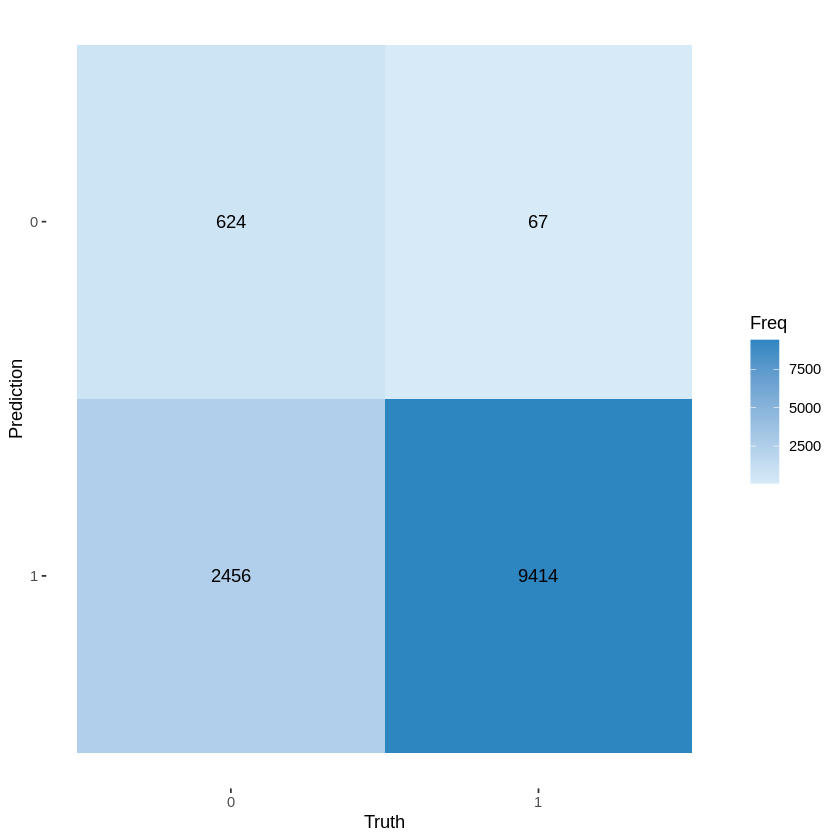

In [ ]:
# Matriz de confusão com o arredondamento das predições
mc <- table(matriz.comparacao[,1],round(matriz.comparacao[,2]))
print(mc)

acc <- sum(diag(mc))/sum(mc)
print(acc)
sum(mc)
sum(diag(mc))

truth_predicted <- data.frame(
  obs = as.vector(matriz.comparacao[,1]),
  pred = as.vector(round(matriz.comparacao[,2]))
)

truth_predicted$obs <- as.factor(truth_predicted$obs)
truth_predicted$pred <- as.factor(truth_predicted$pred)

cm <- conf_mat(truth_predicted, obs, pred)
autoplot(cm, type = "heatmap") + scale_fill_gradient(low="#D6EAF8",high = "#2E86C1") + theme(legend.position = "right")




In [ ]:
# Erro médio

predicted <- matriz.comparacao[,1]
Y_test <- round(matriz.comparacao[,2])

error <- sum(predicted != Y_test)/nrow( as.matrix(matriz.comparacao[,2]))
print(error)


[1] 0.2008598
